In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator, PchipInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pdet import *

/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [2]:
m_keys = ("low", "med")

mc = {key: val for key, val in zip(m_keys, (10, 35))}
mw = {key: val for key, val in zip(m_keys, (5, 5))}
q = {key: val for key, val in zip(m_keys, (0.74, 1))} # q = m2 / m1, with m2 <= m1
zw = {key: val for key, val in zip(m_keys, (0.05, 0.05))}
T_obs = {key: val for key, val in zip(m_keys, (1, 1))}

zinf_axis = {key: np.arange(zinf_min, zinf_max, zw[key]) for key, zinf_min, zinf_max in zip(m_keys, (0, 0), (6, 6))}

bins_axis = {key: [MZQbin(mc[key] - mw[key] / 2,
                          mc[key] + mw[key] / 2,
                          zinf,
                          zinf + zw[key],
                          q[key]) for zinf in zinf_axis[key]] for key in m_keys}

In [3]:
# Initialize the bins before using mapping functions!!
if __name__ == '__main__':
    for key in m_keys:
        bin_initializer(bins_axis[key], T_obs[key])

Initilizing bins: computing VT:   0%|          | 0/120 [00:00<?, ?it/s]/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resourc

In [4]:
N1_N2_axis_res = 0.02
N1_N2_axis = {key: np.arange(val_min, val_max, N1_N2_axis_res) for key, val_min, val_max in zip(m_keys, (0.01, 0.01), (10, 10))}

zref = {key: val for key, val in zip(m_keys, (0.25, 0.25))} # Reference redshift (inferior limit of reference redshift bin)
N2_ref = {key: val for key, val in zip(m_keys, (10, 10))}
bin2_ref = {key: MZQbin(mc[key] - mw[key] / 2, mc[key] + mw[key] / 2, zref[key], zref[key] + zw[key], q[key]) for key in m_keys}

cl = 0.95

# Initialize the bins before using mapping functions!!
for key in m_keys:
    bin2_ref[key].VTmc(T_obs[key])

In [5]:
R1_R2_CI_map = {key: RateRatioBayesCI_map(cl, bin2_ref[key], N1_N2_axis[key], bins_axis[key], N2_ref[key], T_obs[key]) for key in m_keys}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_re

In [6]:
R1_R2_CI_array = {key: np.zeros((len(N1_N2_axis[key]), len(bins_axis[key]), 3)) for key in m_keys}
R1_R2_a_array = {key: np.zeros((len(N1_N2_axis[key]), len(bins_axis[key]))) for key in m_keys}

R1_R2_ref = 1
# 1 if R1_R2_ref is inside confidence interval
Det_map_R1_R2 = {key: None for key in m_keys}

R1_R2_ref_list = [0.5, 1, 2, 3, 5, 10]
# Linked to R1_R2_ref_list on the first dimension. True if the corresponding R1_R2 value is inside the confidence interval
R1_R2_CI_list_mask = {key: np.zeros((len(R1_R2_ref_list), len(N1_N2_axis[key]), len(bins_axis[key])), dtype=bool) for key in m_keys}

# Fill the arrays
for key in m_keys:
    for i, _ in enumerate(N1_N2_axis[key]):
        for j, _ in enumerate(bins_axis[key]):
            R1_R2_CI_array[key][i, j] = np.copy(R1_R2_CI_map[key][i][j][0])
            R1_R2_a_array[key][i, j] = R1_R2_CI_map[key][i][j][2] # a = bin2_ref.VT / bin.VT
                
            for k, R1_R2 in enumerate(R1_R2_ref_list):
                if R1_R2_CI_map[key][i][j][0][0] <= R1_R2 <= R1_R2_CI_map[key][i][j][0][2]:
                    R1_R2_CI_list_mask[key][k, i, j] = True
                    
    Det_map_R1_R2[key] = ((R1_R2_CI_array[key][:, :, 0] <= R1_R2_ref) & (R1_R2_ref <= R1_R2_CI_array[key][:, :, 2])).astype(int)

# For each value in R1_R2_ref_list, select the N1_N2 vs z curves that represents the associated confidence interval
inf_lvl_alpha = {key: np.zeros((len(R1_R2_ref_list), len(bins_axis[key]))) for key in m_keys}
sup_lvl_alpha = {key: np.zeros((len(R1_R2_ref_list), len(bins_axis[key]))) for key in m_keys}

for key in m_keys:
    for i in range(len(R1_R2_ref_list)):
        for j in range(len(bins_axis[key])):
            True_indexes = np.where(R1_R2_CI_list_mask[key][i, :, j])[0]
            if len(True_indexes) != 0:
                inf_lvl_alpha[key][i, j] = N1_N2_axis[key][True_indexes[0]]
                sup_lvl_alpha[key][i, j] = N1_N2_axis[key][True_indexes[-1]]

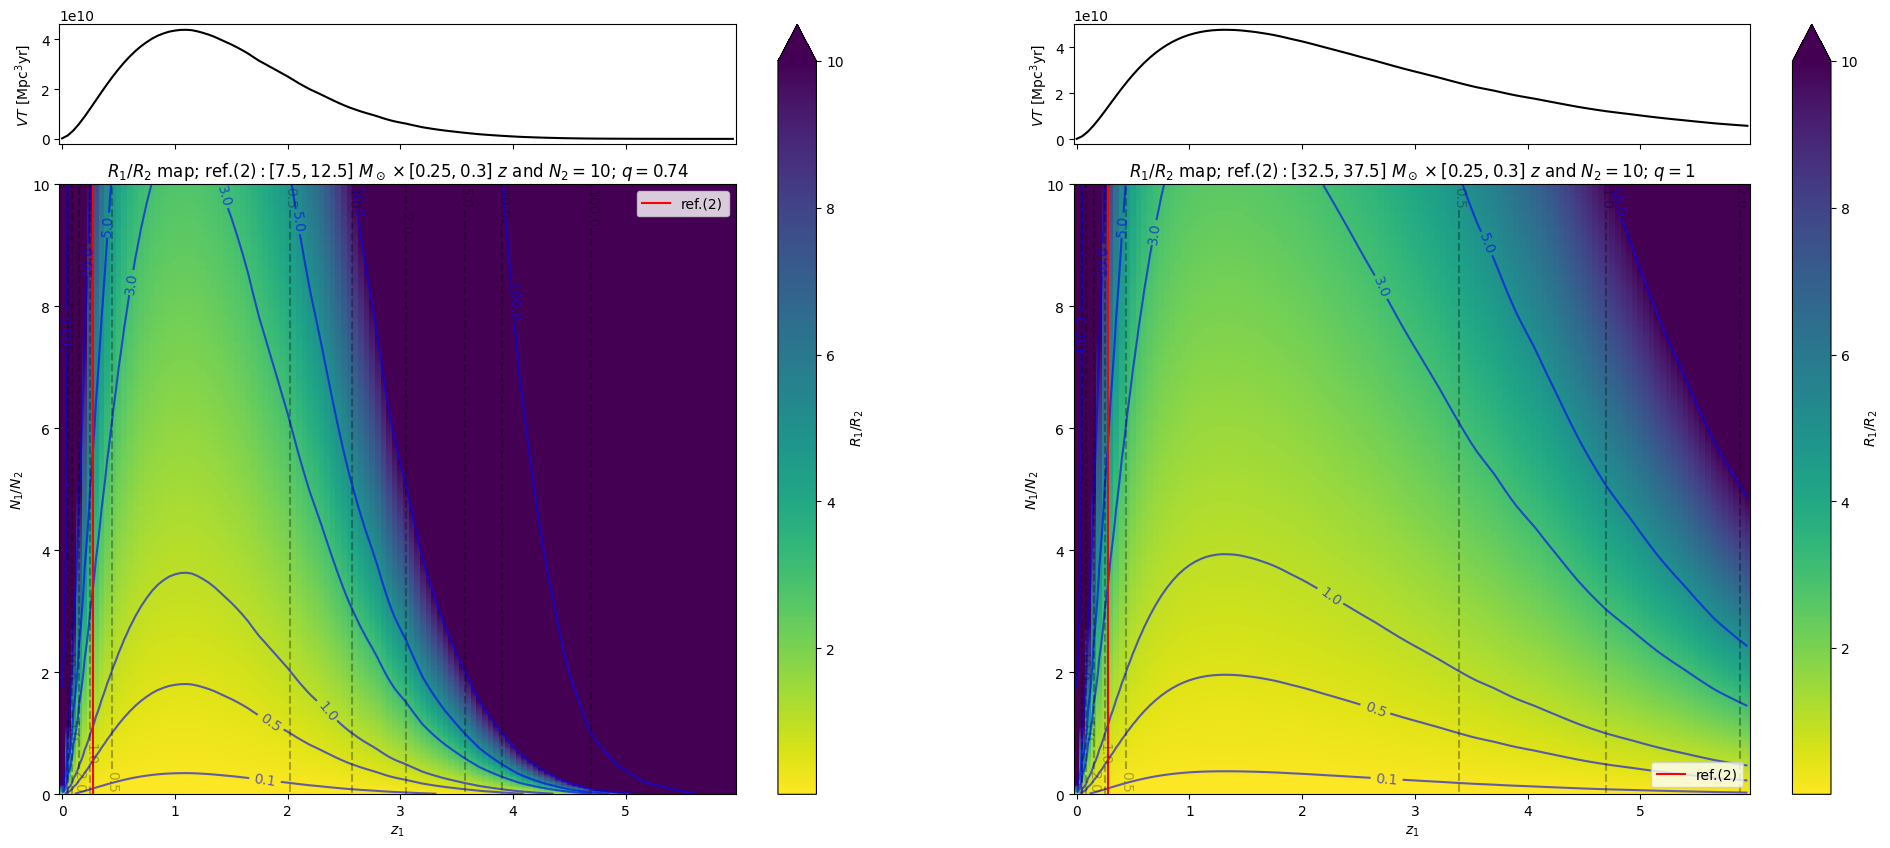

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax, key in zip(axes, m_keys):
    divider = make_axes_locatable(ax)

    ax_VT = divider.append_axes('top', 1.2, pad=0.4, sharex=ax)
    ax_VT.tick_params(labelbottom=False)

    ax.set_title(r'$R_1 / R_2$ map; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$'.format(bin2_ref[key].minf,
                                                                                                                                    bin2_ref[key].msup,
                                                                                                                                    bin2_ref[key].zinf,
                                                                                                                                    np.format_float_positional(bin2_ref[key].zsup, 3),
                                                                                                                                    N2_ref[key],
                                                                                                                                    q[key]))
    ax.set_xlabel(r'$z_1$')
    ax.set_ylabel(r'$N_1 / N_2$')

    # R1/R2 color map
    cmap = plt.colormaps['viridis_r']
    im = ax.pcolormesh(zinf_axis[key], N1_N2_axis[key], R1_R2_CI_array[key][:, :, 1],
                       cmap=cmap, norm=mpl.colors.Normalize(vmin=np.min(R1_R2_CI_array[key][:, :, 1]), vmax=10))
    fig.colorbar(im, ax=ax, label=r'$R_1 / R_2$', extend='max')

    # R1/R2 Contour levels
    cf = ax.contour(zinf_axis[key], N1_N2_axis[key], R1_R2_CI_array[key][:, :, 1],
                    levels=[0.1, 0.5, 1, 3, 5, 10, 100], colors='blue', alpha=0.6)
    ax.clabel(cf)

    # a contour levels
    cf = ax.contour(zinf_axis[key], N1_N2_axis[key], R1_R2_a_array[key],
                    levels=[0.5, 1, 2, 5, 10, 100], colors='black', linestyles='--', alpha=0.3)
    ax.clabel(cf)

    # Reference line for the reference bin
    ax.axvline((bin2_ref[key].zinf + bin2_ref[key].zsup) / 2, color='red', label='ref.(2)')

    ax_VT.set_ylabel(r'$VT\ [\text{Mpc}^3 \text{yr}]$')

    ax_VT.plot(zinf_axis[key], [bin.VT for bin in bins_axis[key]], color='black')

    ax.legend()

plt.show()

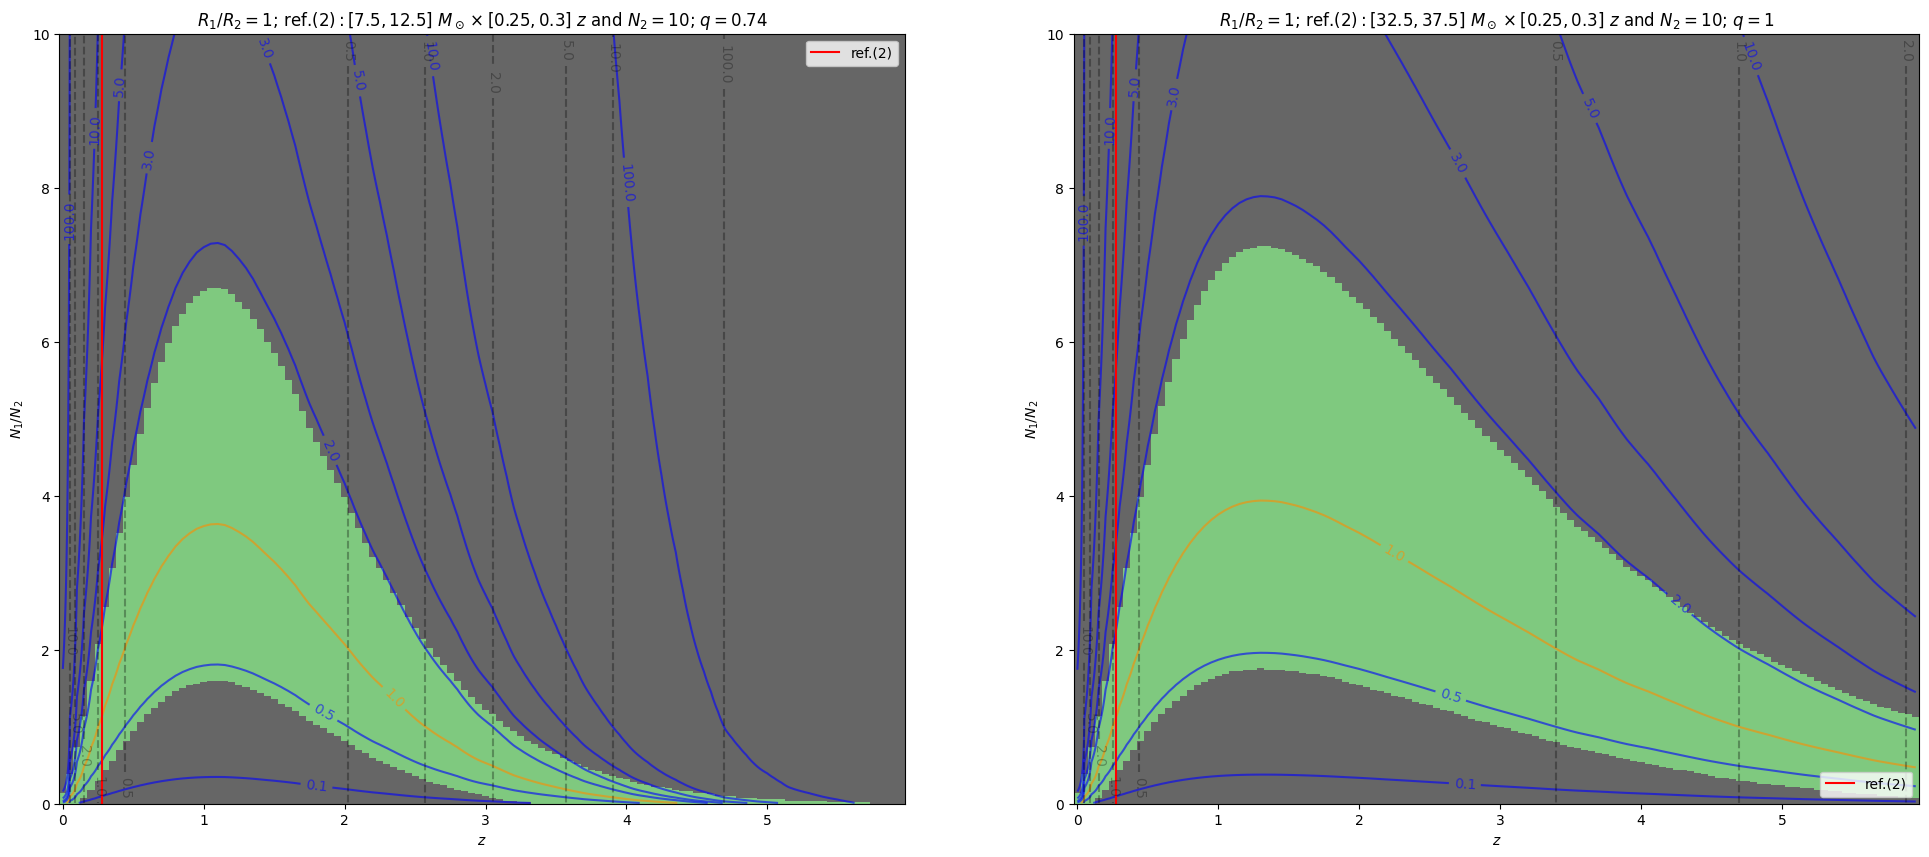

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax, key in zip(axes, m_keys):
    ax.set_title(r'$R_1 / R_2 = {6}$; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$'.format(bin2_ref[key].minf,
                                                                                                                                      bin2_ref[key].msup,
                                                                                                                                      bin2_ref[key].zinf,
                                                                                                                                      np.format_float_positional(bin2_ref[key].zsup, 3),
                                                                                                                                      N2_ref[key],
                                                                                                                                      q[key],
                                                                                                                                      R1_R2_ref))
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$N_1 / N_2$')

    # R1/R2 color map
    cmap = plt.colormaps['Accent_r']
    im = ax.pcolormesh(zinf_axis[key], N1_N2_axis[key], Det_map_R1_R2[key],
                       cmap=cmap)

    # R1/R2 Contour levels
    levels = list(dict.fromkeys(sorted([0.1, 0.5, 1, 2, 3, 5, 10, 100, R1_R2_ref]))) # To avoid duplicates
    colors = ['blue'] * (len(levels))
    colors[levels.index(R1_R2_ref)] = 'darkorange'
    cf = ax.contour(zinf_axis[key], N1_N2_axis[key], R1_R2_CI_array[key][:, :, 1],
                    levels=levels, colors=colors, alpha=0.6)
    ax.clabel(cf)

    # a contour levels
    cf = ax.contour(zinf_axis[key], N1_N2_axis[key], R1_R2_a_array[key],
                    levels=[0.5, 1, 2, 5, 10, 100], colors='black', linestyles='--', alpha=0.3)
    ax.clabel(cf)

    # Reference line for the reference bin
    ax.axvline((bin2_ref[key].zinf + bin2_ref[key].zsup) / 2, color='red', label='ref.(2)')

    ax.legend()

plt.show()

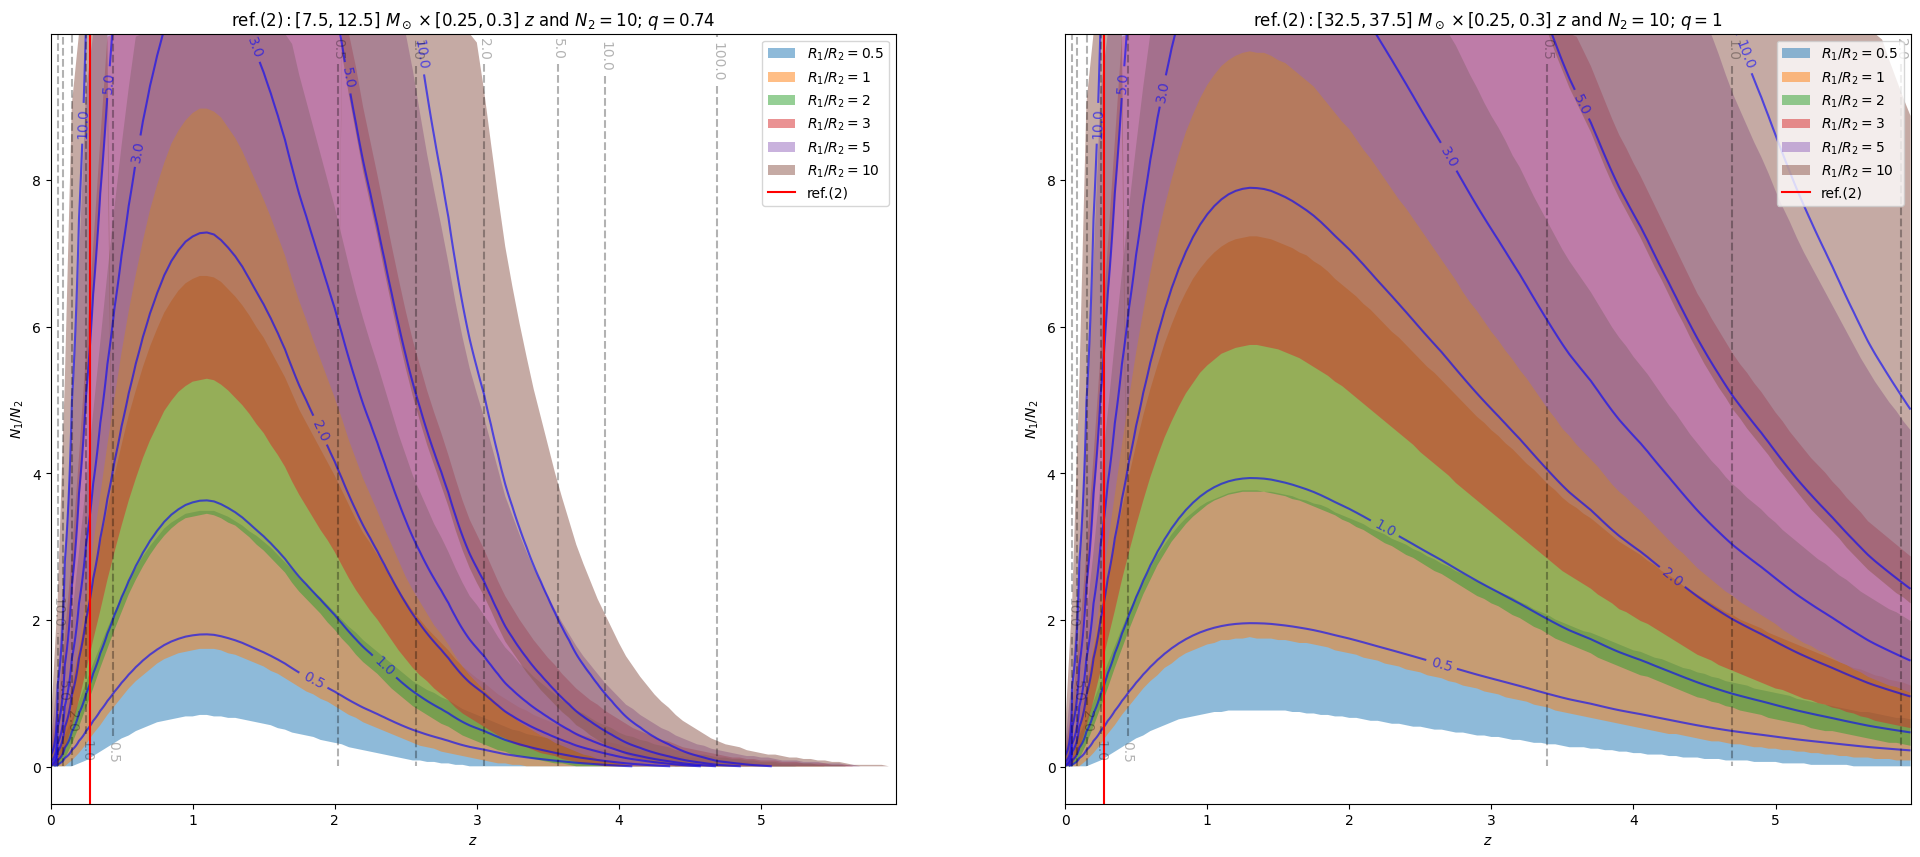

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax, key in zip(axes, m_keys):
    ax.set_title(r'$\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$'.format(bin2_ref[key].minf,
                                                                                                                   bin2_ref[key].msup,
                                                                                                                   bin2_ref[key].zinf,
                                                                                                                   np.format_float_positional(bin2_ref[key].zsup, 3),
                                                                                                                   N2_ref[key],
                                                                                                                   q[key]))
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$N_1 / N_2$')

    # R_1 / R_2 confidence intervals for multiple values of R1_R2_ref and 
    for inf, sup, lb in zip(inf_lvl_alpha[key], sup_lvl_alpha[key], R1_R2_ref_list):
        ax.fill_between(zinf_axis[key], inf, sup, alpha=0.5,
                        label=r'$R_1 / R_2 = {0}$'.format(lb))

    # R1/R2 Contour levels
    cf = ax.contour(zinf_axis[key], N1_N2_axis[key], R1_R2_CI_array[key][:, :, 1],
                    levels=R1_R2_ref_list, colors='blue', alpha=0.6)
    ax.clabel(cf)

    # a contour levels
    cf = ax.contour(zinf_axis[key], N1_N2_axis[key], R1_R2_a_array[key],
                    levels=[0.5, 1, 2, 5, 10, 100], colors='black', linestyles='--', alpha=0.3)
    ax.clabel(cf)

    # Reference line for the reference bin
    ax.axvline((bin2_ref[key].zinf + bin2_ref[key].zsup) / 2, color='red', label='ref.(2)')

    ax.legend()

plt.show()

In [10]:
N1_N2 = 1
R1_R2_CI_ZZmap = {key: RateRatioBayesCI_ZZmap(cl, N1_N2, bins_axis[key], bins_axis[key], N2_ref[key], T_obs[key]) for key in m_keys}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 11248 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 14400 out of 14400 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 11248 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 14400 out of 14400 | elapsed:    2.1s finished


In [11]:
R1_R2_CI_ZZarray = {key: np.zeros((len(bins_axis[key]), len(bins_axis[key]), 3)) for key in m_keys}
R1_R2_a_ZZarray = {key: np.zeros((len(bins_axis[key]), len(bins_axis[key]))) for key in m_keys}

R1_R2_ref = 1
# 1 if R1_R2_ref is inside confidence interval
Det_ZZmap_R1_R2 = {key: None for key in m_keys}

# Fill the arrays
for key in m_keys:
    for i, _ in enumerate(bins_axis[key]):
        for j, _ in enumerate(bins_axis[key]):
            R1_R2_CI_ZZarray[key][i, j] = np.copy(R1_R2_CI_ZZmap[key][i][j][0])
            R1_R2_a_ZZarray[key][i, j] = R1_R2_CI_ZZmap[key][i][j][2] # a = bin2.VT / bin1.VT

    Det_ZZmap_R1_R2[key] = ((R1_R2_CI_ZZarray[key][:, :, 0] <= R1_R2_ref) & (R1_R2_ref <= R1_R2_CI_ZZarray[key][:, :, 2])).astype(int)

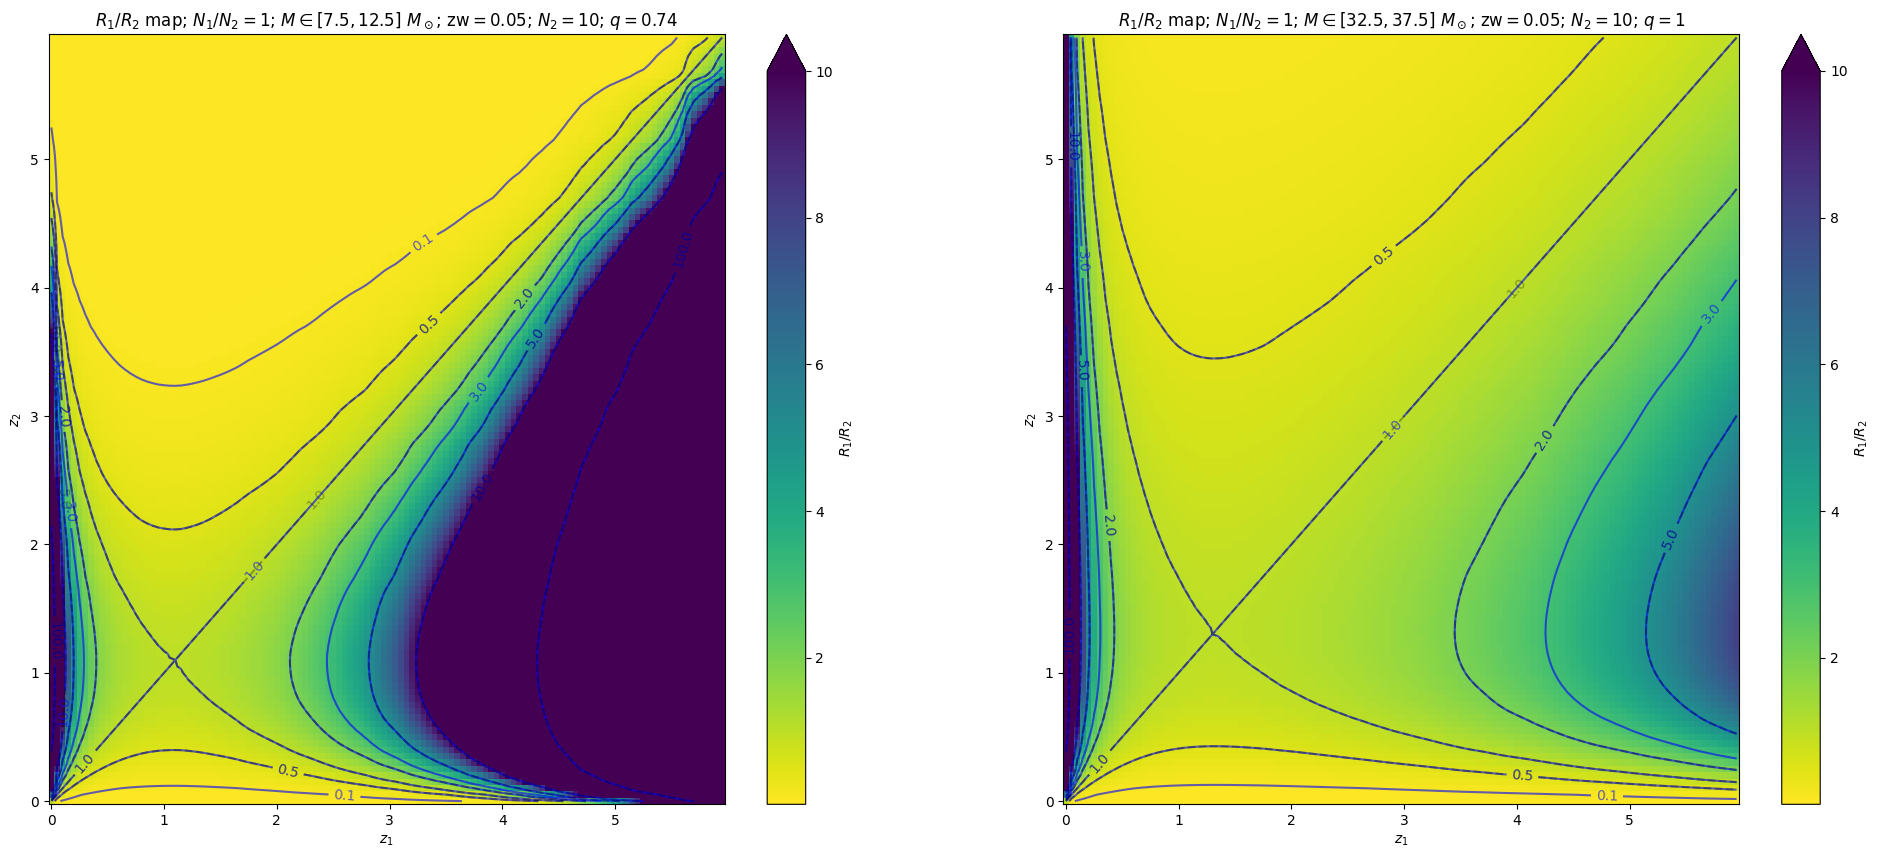

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax, key in zip(axes, m_keys):
    ax.set_title(r'$R_1 / R_2$ map; $N_1 / N_2 = {0}$; $M \in [{1}, {2}]\ M_\odot$; $\text{{zw}} = {3}$; $N_2 = {4}$; $q = {5}$'.format(N1_N2,
                                                                                                                                        bins_axis[key][0].minf,
                                                                                                                                        bins_axis[key][0].msup,
                                                                                                                                        zw[key],
                                                                                                                                        N2_ref[key],
                                                                                                                                        q[key]))
    ax.set_xlabel(r'$z_1$')
    ax.set_ylabel(r'$z_2$')
    # R1/R2 color map
    cmap = plt.colormaps['viridis_r']
    im = ax.pcolormesh(zinf_axis[key], zinf_axis[key], R1_R2_CI_ZZarray[key][:, :, 1],
                       cmap=cmap, norm=mpl.colors.Normalize(vmin=np.min(R1_R2_CI_ZZarray[key][:, :, 1]), vmax=10))
    fig.colorbar(im, ax=ax, label=r'$R_1 / R_2$', extend='max')

    # R1/R2 Contour levels
    cf = ax.contour(zinf_axis[key], zinf_axis[key], R1_R2_CI_ZZarray[key][:, :, 1],
                    levels=[0.1, 0.5, 1, 2, 3, 5, 10, 100], colors='blue', alpha=0.6)
    ax.clabel(cf)

    # a contour levels
    cf = ax.contour(zinf_axis[key], zinf_axis[key], R1_R2_a_ZZarray[key],
                    levels=[0.5, 1, 2, 5, 10, 100], colors='black', linestyles='--', alpha=0.3)
    ax.clabel(cf)

plt.show()

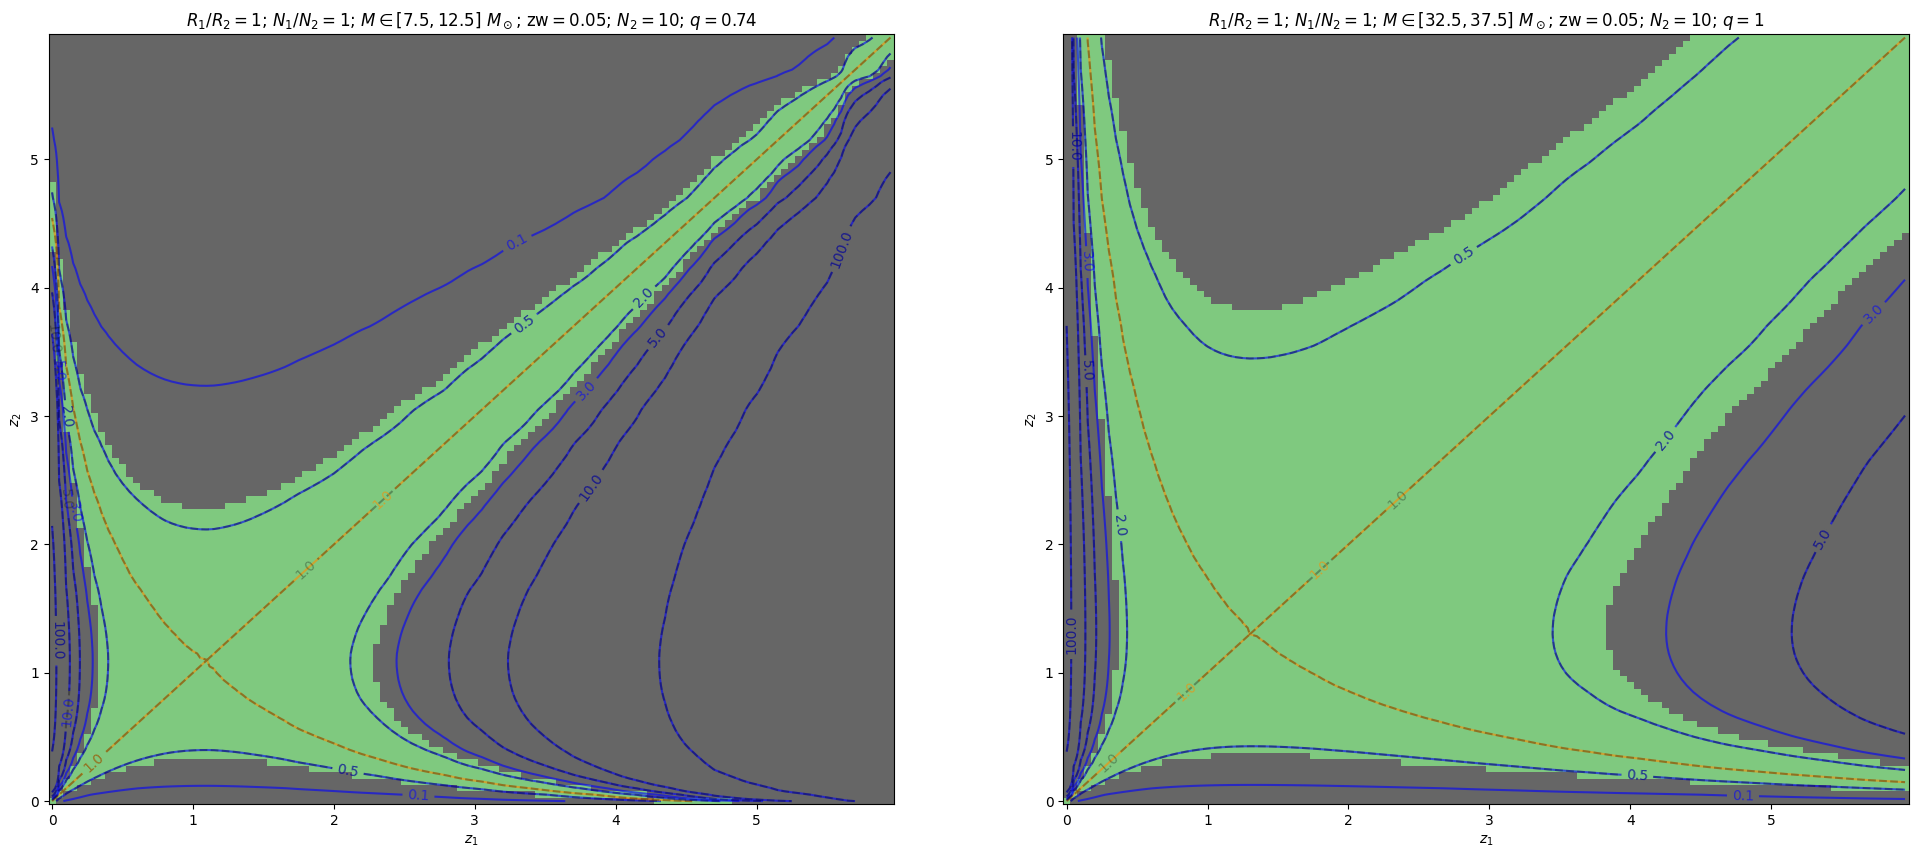

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax, key in zip(axes, m_keys):
    ax.set_title(r'$R_1 / R_2 = {6}$; $N_1 / N_2 = {0}$; $M \in [{1}, {2}]\ M_\odot$; $\text{{zw}} = {3}$; $N_2 = {4}$; $q = {5}$'.format(N1_N2,
                                                                                                                                          bins_axis[key][0].minf,
                                                                                                                                          bins_axis[key][0].msup,
                                                                                                                                          zw[key],
                                                                                                                                          N2_ref[key],
                                                                                                                                          q[key],
                                                                                                                                          R1_R2_ref))
    ax.set_xlabel(r'$z_1$')
    ax.set_ylabel(r'$z_2$')

    # R1/R2 color map
    cmap = plt.colormaps['Accent_r']
    im = ax.pcolormesh(zinf_axis[key], zinf_axis[key], Det_ZZmap_R1_R2[key],
                       cmap=cmap)

    # R1/R2 Contour levels
    levels = list(dict.fromkeys(sorted([0.1, 0.5, 1, 2, 3, 5, 10, 100, R1_R2_ref]))) # To avoid duplicates
    colors = ['blue'] * (len(levels))
    colors[levels.index(R1_R2_ref)] = 'darkorange'
    cf = ax.contour(zinf_axis[key], zinf_axis[key], R1_R2_CI_ZZarray[key][:, :, 1],
                    levels=levels, colors=colors, alpha=0.6)
    ax.clabel(cf)

    # a contour levels
    cf = ax.contour(zinf_axis[key], zinf_axis[key], R1_R2_a_ZZarray[key],
                    levels=[0.5, 1, 2, 5, 10, 100], colors='black', linestyles='--', alpha=0.3)
    ax.clabel(cf)

plt.show()